In [3]:
import os
import random
import shutil

from multiprocessing.dummy import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split
# from sklearn.externals import joblib

from skimage.morphology import binary_opening, disk, label

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms

# Семнатическая сегментация

В рамках данного ноутбука мы будем решать задачу по мотивам https://www.kaggle.com/competitions/airbus-ship-detection

В исходной задаче необходимо детектировать корабли, мы же будем проводить сегентмацию. Мы также упростим задачу с точки зрения рамезра изображений, чтобы получить необходимый нам учебный результат за размумное время.

## Подготовка набора данных

Исходная база изображени содержит сотню тысяч фотографий моря со спутника, на некоторых из которых есть контейнеровозы, а на некоторых нет. Обратите внимание, это сотня гигабайт объёма.

Кроме того есть файл csv, содеражщий маски.

In [ ]:
train_dpath = '../input/train_v2/'
test_dpath = '../input/test_v2/'

anno_fpath = 'train_ship_segmentations_v2.csv'
bst_model_fpath = 'model/bst_unet.model'

sample_submission_fpath = '../input/sample_submission_v2.csv'
submission_fpath = 'submission.csv'

excluded_filenames = ['6384c3e78.jpg', ]
original_img_size = (768, 768)

In [ ]:
imgs = ['/content/0005d01c8.jpg', '/content/000194a2d.jpg']

In [ ]:
annos = pd.read_csv(anno_fpath)
annos = annos[~annos['ImageId'].isin(excluded_filenames)]

In [ ]:
annos.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [ ]:
annos.describe()

,EncodedPixels_flag
count,231722.000000
mean,0.352677
std,0.477804
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Разделим фотографии на два типа: содержащие корабли и без кораблей.

In [ ]:
img = '0005d01c8.jpg'

annos[annos['ImageId'] == '0005d01c8.jpg']

,ImageId,EncodedPixels,EncodedPixels_flag
29,0005d01c8.jpg,56010 1 56777 3 57544 6 58312 7 59079 9 59846 ...,1
30,0005d01c8.jpg,365871 1 366638 3 367405 6 368173 7 368940 9 3...,1


In [ ]:
annos.loc[annos['ImageId'] == '0005d01c8.jpg', 'EncodedPixels'].values

array(['56010 1 56777 3 57544 6 58312 7 59079 9 59846 11 60613 14 61380 16 62148 17 62915 19 63682 22 64449 24 65216 26 65984 27 66751 30 67518 32 68285 34 69052 36 69820 38 70587 40 71354 42 72121 42 72888 42 73656 42 74423 42 75190 42 75957 42 76724 42 77492 42 78259 42 79026 42 79793 42 80560 42 81328 42 82095 42 82862 42 83629 42 84396 42 85164 42 85931 42 86698 42 87465 42 88232 42 89000 42 89767 42 90534 42 91301 42 92068 42 92836 42 93603 42 94370 42 95137 42 95904 42 96672 42 97439 42 98206 42 98973 42 99740 42 100508 42 101275 42 102042 42 102809 42 103576 42 104344 42 105111 42 105878 42 106645 42 107412 42 108180 42 108947 42 109714 42 110481 42 111249 41 112016 42 112783 42 113550 42 114317 42 115085 41 115852 42 116619 42 117386 42 118153 42 118921 41 119688 42 120455 42 121222 42 121989 42 122757 41 123524 42 124291 42 125058 42 125825 42 126593 42 127360 42 128127 42 128894 42 129661 42 130429 42 131196 42 131963 42 132730 42 133497 42 134265 42 135032 42 135799 42 13656

In [ ]:
annos['EncodedPixels_flag'] = annos['EncodedPixels'].map(lambda v: 1 if isinstance(v, str) else 0)
annos

,ImageId,EncodedPixels,EncodedPixels_flag
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
...,...,...,...
231718,fffedbb6b.jpg,NaN,0
231719,ffff2aa57.jpg,NaN,0
231720,ffff6e525.jpg,NaN,0
231721,ffffc50b4.jpg,NaN,0


In [ ]:
imgs = annos.groupby('ImageId').agg({'EncodedPixels_flag': 'sum'}).reset_index().rename(columns={'EncodedPixels_flag': 'ships'})
imgs

,ImageId,ships
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0
...,...,...
192550,fffedbb6b.jpg,0
192551,ffff2aa57.jpg,0
192552,ffff6e525.jpg,0
192553,ffffc50b4.jpg,0


In [ ]:
print(len(imgs[imgs['ships'] > 0]))
# 192 555
# 42 556

42556


In [ ]:
imgs_w_ships = imgs[imgs['ships'] > 0]
imgs_wo_ships = imgs[imgs['ships'] == 0].sample(20000, random_state=69278)

selected_imgs = pd.concat((imgs_w_ships, imgs_wo_ships))
selected_imgs['has_ship'] = selected_imgs['ships'] > 0

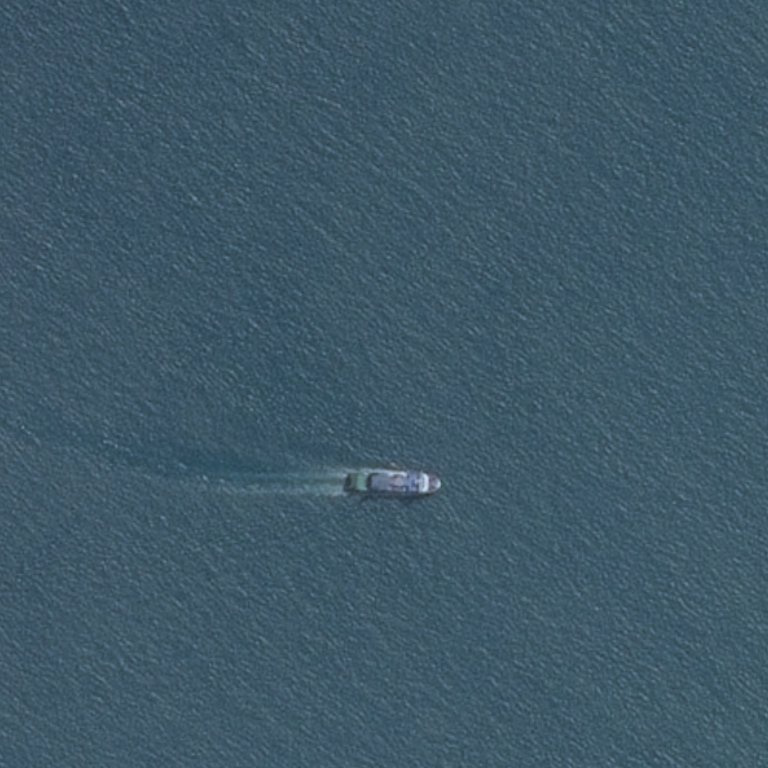

In [ ]:
Image.open(train_dpath + imgs_w_ships.iloc[0]['ImageId'])

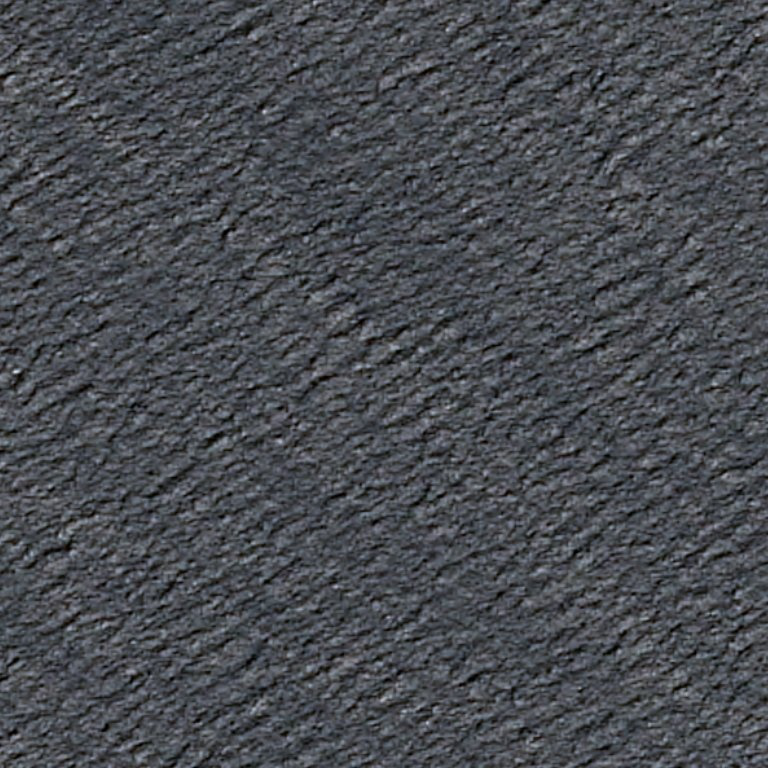

In [ ]:
Image.open(train_dpath + imgs_wo_ships.iloc[0]['ImageId'])

In [ ]:
train_imgs, val_imgs = train_test_split(selected_imgs, test_size=0.15, stratify=selected_imgs['has_ship'], random_state=69278)

train_fnames = train_imgs['ImageId'].values
val_fnames = val_imgs['ImageId'].values

**Оставим только 10% объектов.**

In [ ]:
_, train_fnames = train_test_split(train_fnames, test_size=0.1, random_state=69278)
_, val_fnames = train_test_split(val_fnames, test_size=0.1, random_state=69278)

In [ ]:
print("Train ", len(train_fnames), "val", len(val_fnames))

Train  5318 val 939


## Набор данных

Нам необходимо правильно переработать входные данные таким образом, чтобы изображения и маски совпадали в размерах и могли быть интерпретированны моделью машинного обучения. Для этого надо научиться читать формат данных файла.

In [ ]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    ends = starts + lengths
    im = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        im[lo:hi] = 1
    return im.reshape(shape).T

def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    runs[::2] -= 1
    return ' '.join(str(x) for x in runs)

In [ ]:
class ImgDataset(Dataset):

    def __init__(self,
                 img_dpath,
                 img_fnames,
                 img_transform,
                 mask_encodings=None,
                 mask_size=None,
                 mask_transform=None):

        self.img_dpath = img_dpath
        self.img_fnames = img_fnames
        self.img_transform = img_transform

        self.mask_encodings = mask_encodings
        self.mask_size = mask_size
        self.mask_transform = mask_transform

    def __getitem__(self, i):
        # https://github.com/pytorch/vision/issues/9#issuecomment-304224800
        seed = np.random.randint(2147483647)

        fname = self.img_fnames[i]
        fpath = os.path.join(self.img_dpath, fname)
        img = Image.open(fpath)
        if self.img_transform is not None:
            random.seed(seed)
            img = self.img_transform(img)

        if self.mask_encodings is None:
            return img, fname

        if self.mask_size is None or self.mask_transform is None:
            raise ValueError('If mask_dpath is not None, mask_size and mask_transform must not be None.')

        mask = np.zeros(self.mask_size, dtype=np.uint8)
        if self.mask_encodings[fname][0] == self.mask_encodings[fname][0]: # NaN doesn't equal to itself
            for encoding in self.mask_encodings[fname]:
                mask += rle_decode(encoding, self.mask_size)
        mask = np.clip(mask, 0, 1)

        mask = Image.fromarray(mask)

        random.seed(seed)
        mask = self.mask_transform(mask)

        return img, torch.from_numpy(np.array(mask, dtype=np.int64))

    def __len__(self):
        return len(self.img_fnames)

In [ ]:
def get_mask_encodings(annos, fnames):
    a = annos[annos['ImageId'].isin(fnames)]
    return a.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.tolist()).to_dict()


Получив набор данных, зададим необходимые ппраметы, в том числе уменьшим изображения до 80 х 80. Для решения задачи хвтит трёх эпох.

$mAP_c = \frac{1}{N} \sum_{i=1}^N AP_{c,\tau_i}$

In [ ]:
class param:
    img_size = (80, 80)
    bs = 8
    num_workers = 4
    lr = 0.001
    epochs = 3
    unet_depth = 5
    unet_start_filters = 8
    log_interval = 70 # less then len(train_dl)

In [ ]:
train_tfms = transforms.Compose([transforms.Resize(param.img_size),
                                 transforms.ToTensor()])

val_tfms = transforms.Compose([transforms.Resize(param.img_size),
                               transforms.ToTensor()])

mask_tfms = transforms.Compose([transforms.Resize(param.img_size)])

In [ ]:
train_ds = ImgDataset(train_dpath,
                      train_fnames,
                      train_tfms,
                      get_mask_encodings(annos, train_fnames),
                      original_img_size,
                      mask_tfms)

test_ds = ImgDataset(train_dpath,
                     val_fnames,
                     val_tfms, get_mask_encodings(annos, val_fnames), original_img_size, mask_tfms)

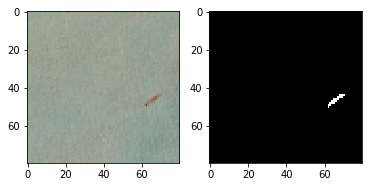

In [ ]:
img, mask = train_ds[0]
plt.subplot(121)
plt.imshow(img.permute(1,2,0))
plt.subplot(122)
plt.imshow(mask, cmap='gray')
plt.show()

## Модель и её подготовка

Нам необходимо реализовать свёрточные и развёрточные слои. Для примера сделаем их сами.

In [ ]:
def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=1,
                     groups=groups,
                     stride=1)

def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=3,
                     stride=stride,
                     padding=padding,
                     bias=bias,
                     groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(in_channels,
                                  out_channels,
                                  kernel_size=2,
                                  stride=2)
    else:
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

In [ ]:
class DownConv(nn.Module):
    """
    Свёрточный модуль.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool

class UpConv(nn.Module):
    """
    Развёрточный модуль.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 merge_mode='concat',
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels,
                                self.out_channels,
                                mode=self.up_mode)

        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(2*self.out_channels,
                                 self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)

        self.conv2 = conv3x3(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        """ Прямой проход
        Arguments:
            from_down: тензор из прохода, который приводил к понижению размерности
            from_up: тензор из текущего прохода, приводяйщий к росту
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

In [ ]:
class UNet(nn.Module):
    """ `UNet` class is based on https://arxiv.org/abs/1505.04597
    The U-Net is a convolutional encoder-decoder neural network.
    Contextual spatial information (from the decoding,
    expansive pathway) about an input tensor is merged with
    information representing the localization of details
    (from the encoding, compressive pathway).
    Modifications to the original paper:
    (1) padding is used in 3x3 convolutions to prevent loss
        of border pixels
    (2) merging outputs does not require cropping due to (1)
    (3) residual connections can be used by specifying
        UNet(merge_mode='add')
    (4) if non-parametric upsampling is used in the decoder
        pathway (specified by upmode='upsample'), then an
        additional 1x1 2d convolution occurs after upsampling
        to reduce channel dimensionality by a factor of 2.
        This channel halving happens with the convolution in
        the tranpose convolution (specified by upmode='transpose')
    """

    def __init__(self, num_classes, in_channels=3, depth=5,
                 start_filts=64, up_mode='transpose',
                 merge_mode='concat'):
        """
        Arguments:
            in_channels: int, number of channels in the input tensor.
                Default is 3 for RGB images.
            depth: int, number of MaxPools in the U-Net.
            start_filts: int, number of convolutional filters for the
                first conv.
            up_mode: string, type of upconvolution. Choices: 'transpose'
                for transpose convolution or 'upsample' for nearest neighbour
                upsampling.
        """
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))

        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(up_mode))

        # NOTE: up_mode 'upsample' is incompatible with merge_mode 'add'
        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError("up_mode \"upsample\" is incompatible "
                             "with merge_mode \"add\" at the moment "
                             "because it doesn't make sense to use "
                             "nearest neighbour to reduce "
                             "depth channels (by half).")

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        # create the decoder pathway and add to a list
        # - careful! decoding only requires depth-1 blocks
        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal(m.weight)
            nn.init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        encoder_outs = []

        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)

        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        x = self.conv_final(x)
        return x

## Обучение

In [ ]:
train_dl = DataLoader(train_ds,
                      batch_size=param.bs,
                      shuffle=True,
                      pin_memory=torch.cuda.is_available(),
                      num_workers=param.num_workers)

val_dl = DataLoader(test_ds,
                    batch_size=param.bs,
                    shuffle=False,
                    pin_memory=torch.cuda.is_available(),
                    num_workers=param.num_workers)

model = UNet(2,
             depth=param.unet_depth,
             start_filts=param.unet_start_filters,
             merge_mode='concat').cuda()

optim = torch.optim.Adam(model.parameters(), lr=param.lr)

In [ ]:
def get_loss(dl, model):
    loss = 0
    for X, y in dl:
        X, y = Variable(X).cuda(), Variable(y).cuda()
        output = model(X)
        loss += F.cross_entropy(output, y).data.cpu().numpy()[0]
    loss = loss / len(dl)
    return loss

In [ ]:
iters = []
train_losses = []
val_losses = []

it = 0
min_loss = np.inf

model.train()
for epoch in range(param.epochs):
    for i, (X, y) in enumerate(train_dl):
        X = Variable(X).cuda()  # [N, 1, H, W]
        y = Variable(y).cuda()  # [N, H, W] with class indices (0, 1)
        output = model(X)  # [N, 2, H, W]
        loss = F.cross_entropy(output, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if (i + 1) % param.log_interval == 0:
            it += param.log_interval * param.bs
            iters.append(it)
            print(loss.data.cpu().numpy()[0])
            train_losses.append(loss.data.cpu().numpy()[0])

            model.eval()
            val_loss = get_loss(val_dl, model)
            model.train()
            val_losses.append(val_loss)


model.eval()
val_loss = get_loss(val_dl, model)

0.12199113
0.014713993
0.03514929
0.023894735
0.03138596
0.017029606
0.013901932
0.013239448
0.033647407
0.004945421
0.02947486
0.060232982
0.03196821
0.02422302
0.051737536
0.016058376
0.027290525
0.022502415
0.020309066
0.0075358497
0.02965732
0.0137133
0.037105087
0.013469401
0.0034729766
0.016277727
0.007738043


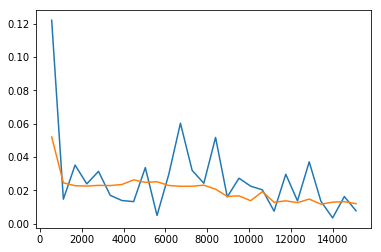

In [ ]:
plt.plot(iters, train_losses)
plt.plot(iters, val_losses)
plt.show()

## Применение результата

In [ ]:
model.eval()
for X, masks in val_dl:
    X = X.cuda()
    output = model(Variable(X))
    break

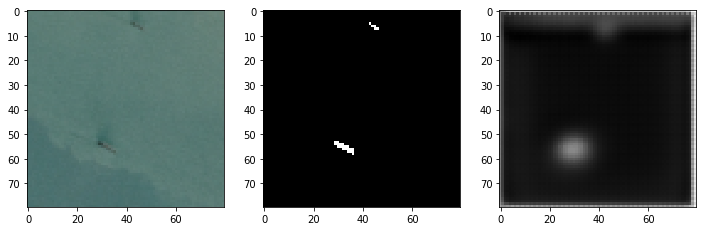

In [ ]:
num_item = 5
image, mask, predicted = X[num_item],  masks[num_item], output[num_item, 1]
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(image.permute(1,2,0).cpu())
plt.subplot(132)
plt.imshow(mask.cpu(), cmap='gray')
plt.subplot(133)
plt.imshow(predicted.data.cpu().numpy(), cmap='gray')
plt.show()